Steps:-
1. train a classifier with data augmentation by keeping the convolution base frozen
2. make last few layers of convolution base as trainable
3. compile and train the model again so that fine tuning can happen and the convolution base can become more task specific

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nitishpandey04","key":"25e697bcb9f519cb2af5d5a7c19f2874"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

 97% 791M/812M [00:03<00:00, 268MB/s]
100% 812M/812M [00:03<00:00, 266MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

In [7]:
import os, shutil, pathlib

In [8]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [9]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Making train, test and validation dataset objects

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Getting the convolution base

In [11]:
conv_base = keras.applications.vgg16.VGG16(include_top=False, input_shape=(180, 180, 3))
conv_base.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


Defining Model Architecture

In [12]:
data_augmentation = keras.Sequential([
                                    layers.RandomFlip("horizontal"),
                                    layers.RandomRotation(0.1),
                                    layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=["accuracy"])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

In [14]:
callbacks = [
             keras.callbacks.ModelCheckpoint(filepath="FE_with_DA.keras",
                                             monitor="val_loss",
                                             save_best_only=True)
]

In [15]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 26s 203ms/step - loss: 21.1717 - accuracy: 0.8890 - val_loss: 8.8768 - val_accuracy: 0.9490
Epoch 2/50
63/63 [==============================] - 11s 172ms/step - loss: 7.4478 - accuracy: 0.9450 - val_loss: 5.1951 - val_accuracy: 0.9700
Epoch 3/50
63/63 [==============================] - 11s 172ms/step - loss: 6.3936 - accuracy: 0.9580 - val_loss: 3.5996 - val_accuracy: 0.9700
Epoch 4/50
63/63 [==============================] - 11s 173ms/step - loss: 4.6737 - accuracy: 0.9635 - val_loss: 2.9170 - val_accuracy: 0.9760
Epoch 5/50
63/63 [==============================] - 11s 169ms/step - loss: 3.9210 - accuracy: 0.9670 - val_loss: 5.3999 - val_accuracy: 0.9670
Epoch 6/50
63/63 [==============================] - 11s 171ms/step - loss: 3.0675 - accuracy: 0.9690 - val_loss: 8.0211 - val_accuracy: 0.9610
Epoch 7/50
63/63 [==============================] - 11s 170ms/step - loss: 4.2722 - accuracy: 0.9650 - val_loss: 3.5540 - val_accuracy: 0.978

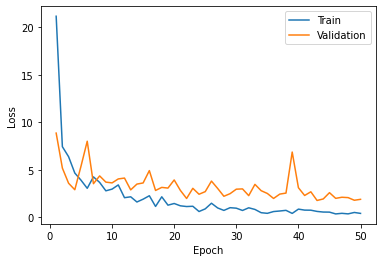

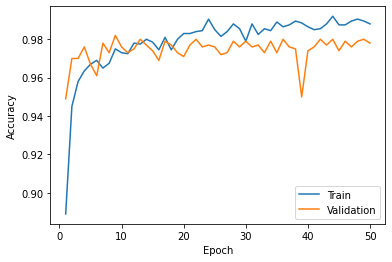

In [16]:
plt.plot(range(1, 51), history.history["loss"], label="Train")
plt.plot(range(1, 51), history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.plot(range(1, 51), history.history["accuracy"], label="Train")
plt.plot(range(1, 51), history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Now we'll change the trainable state of last few layers of Convolution Base to fine tune them.

In [17]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [18]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [19]:
callbacks = [
             keras.callbacks.ModelCheckpoint(filepath="fine_tuning.keras",
                                             save_best_only=True,
                                             monitor="val_loss")
]

In [20]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 15s 200ms/step - loss: 0.2319 - accuracy: 0.9940 - val_loss: 3.2815 - val_accuracy: 0.9710
Epoch 2/30
63/63 [==============================] - 13s 198ms/step - loss: 0.2760 - accuracy: 0.9920 - val_loss: 1.8583 - val_accuracy: 0.9810
Epoch 3/30
63/63 [==============================] - 13s 197ms/step - loss: 0.5140 - accuracy: 0.9920 - val_loss: 1.7481 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 12s 192ms/step - loss: 0.3956 - accuracy: 0.9915 - val_loss: 2.3307 - val_accuracy: 0.9750
Epoch 5/30
63/63 [==============================] - 12s 193ms/step - loss: 0.2888 - accuracy: 0.9900 - val_loss: 2.5815 - val_accuracy: 0.9740
Epoch 6/30
63/63 [==============================] - 13s 198ms/step - loss: 0.4208 - accuracy: 0.9885 - val_loss: 1.7073 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 13s 199ms/step - loss: 0.2514 - accuracy: 0.9925 - val_loss: 1.6291 - val_accuracy: 0.9780

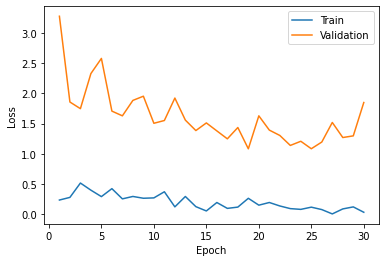

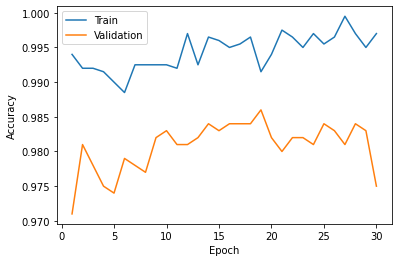

In [22]:
plt.plot(range(1, 31), history.history["loss"], label="Train")
plt.plot(range(1, 31), history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.plot(range(1, 31), history.history["accuracy"], label="Train")
plt.plot(range(1, 31), history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Comparing feature extraction with data augmentation model and fine tuning model
- we expect the fine tuning model to do better because it is built upon the other

In [23]:
fe_with_da = keras.models.load_model("FE_with_DA.keras")
fine_tuning = keras.models.load_model("fine_tuning.keras")

In [24]:
fe_with_da.evaluate(test_dataset)

63/63 [==============================] - 7s 108ms/step - loss: 2.2019 - accuracy: 0.9765


[2.2018609046936035, 0.9764999747276306]

In [25]:
fine_tuning.evaluate(test_dataset)

63/63 [==============================] - 7s 108ms/step - loss: 1.8198 - accuracy: 0.9745


[1.8198293447494507, 0.9745000004768372]

- Surprisingly, fine tuned model has 0.2 % less accuracy than feature extraction model
- But, the loss value of fine tuned model is less than the other one.